In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import scipy as sp
import seaborn as sns
from scipy import stats
import bayes_toolbox.glm as bg

sns.set_theme("talk")
sns.set_style("darkgrid")

%matplotlib inline
%config Inline.figure_format = 'retina'

In [2]:
df = pd.read_csv("../results/ige_ege_jump.csv")
df["adaptation"] = np.nan
df["total error"] = np.nan
df.columns

Index(['si', 'SN', 'id', 'tester', 'TN', 'move_cycle', 'hX', 'hY', 'rot_hX',
       'rot_hY', 'rotation', 'tgt_jump', 'hand_max_dist', 'radvelmax', 'tgtX',
       'tgtY', 'rot_hand_theta', 'theta_maxradv', 'raw_ep_hand_ang', 'tgt_ang',
       'tgt_dist', 'fbi', 'MT', 'RT', 'ST', 'adaptation', 'total error'],
      dtype='object')

In [3]:
df.head()

,si,SN,id,tester,TN,move_cycle,hX,hY,rot_hX,rot_hY,...,theta_maxradv,raw_ep_hand_ang,tgt_ang,tgt_dist,fbi,MT,RT,ST,adaptation,total error
0,1,1,01_i,s,1,1,2.556301,88.878669,0.0,0.0,...,6.199063,91.647469,90,90,1,0.622884,10.843442,5.611307,NaN,NaN
1,1,1,01_i,s,2,2,3.566301,88.868669,0.0,0.0,...,4.738781,92.298047,90,90,1,0.508572,0.882459,1.620206,NaN,NaN
2,1,1,01_i,s,3,3,3.686301,94.458669,0.0,0.0,...,-1.422603,92.234865,90,90,1,0.255398,2.651180,1.312924,NaN,NaN
3,1,1,01_i,s,4,4,2.756301,89.038669,0.0,0.0,...,-0.279086,91.773095,90,90,1,0.396111,0.398744,1.336725,NaN,NaN
4,1,1,01_i,s,5,5,2.666301,86.048669,0.0,0.0,...,-3.255367,91.774797,90,90,1,0.275479,0.419456,1.269343,NaN,NaN


In [4]:
# Outlier removal
z_thresh = 4

# z-score hand angle data
df["theta_maxradv_z"] = df.groupby("SN")["theta_maxradv"].transform(stats.zscore)

# Create outlier column
df["theta_maxradv_outlier"] = np.abs(df["theta_maxradv_z"]) > z_thresh

# Calculate within-subject mean using non-outlier trials only
df["theta_maxradv_mean"] = df[np.abs(df["theta_maxradv_z"]) <= z_thresh].groupby("SN")["theta_maxradv"].transform(np.mean)

# Replace outliers with within-subject mean values
df["theta_maxradv_mean"] = df.groupby("SN")["theta_maxradv_mean"].transform(lambda x: x.fillna(np.nanmean(x)))

# Create final column with "cleaned" hand angles
df["theta_maxradv_clean"] = np.where(np.abs(df["theta_maxradv_z"]) > z_thresh,
                                     df["theta_maxradv_mean"],
                                     df["theta_maxradv"])

# df[np.abs(df["theta_maxradv_z"]) > z_thresh].sample(10)

### Writing custom-function for outlier removal

In [5]:
# def replace_outliers(z_thresh, var, subj_id):
    
#     # z-score var
#     df["var" + "_z"] = df.groupby(subj_id)[var].transform(stats.zscore)
    
#     # Create outlier column
#     df["var" + "_outlier"] = np.abs(df["var_z"]) > z_thresh

#     # Calculate within-subject mean using non-outlier trials only
#     df["var" + "_mean"] = df[np.abs(df["var_z"]) <= z_thresh].groupby("subj_id")["var"].transform(np.mean)

#     # Replace outliers with within-subject mean values
#     df["var_mean"] = df.groupby("subj_id")["var_mean"].transform(lambda x: x.fillna(np.nanmean(x)))

#     # Create final column with "cleaned" hand angles
#     df["var" + "_clean"] = np.where(np.abs(df["var_z"]) > z_thresh,
#                                      df["var_mean"],
#                                      df["var"])
    
#     return df["var_z"]

In [6]:
# View sample of rows to confirm hand angle varies by subject
df[df["theta_maxradv_z"] > z_thresh].sample()

# Count number of outliers per participant
df.groupby("SN")["theta_maxradv_outlier"].sum()

# Check by again printing a sample of outlier rows
df[df["theta_maxradv_z"] > z_thresh].sample()

,si,SN,id,tester,TN,move_cycle,hX,hY,rot_hX,rot_hY,...,fbi,MT,RT,ST,adaptation,total error,theta_maxradv_z,theta_maxradv_outlier,theta_maxradv_mean,theta_maxradv_clean
9354,6,6,06_i,s,5,5,1.606301,90.678669,0.0,0.0,...,1,0.623758,0.433158,1.603894,NaN,NaN,4.426233,True,0.398267,0.398267


In [7]:
# # Find outliers and remove based on hard threshold
# outlier_idx = np.where(np.abs(df.theta_maxradv) >= 45)
# outlier_idx = np.asarray(outlier_idx).flatten()
# print(f'Total number of outliers: ', len(outlier_idx))
# cols = ["rotation", "rot_hand_theta", "theta_maxradv", "raw_ep_hand_ang", "MT", "RT"]
# df.loc[outlier_idx, cols] = np.nan


In [8]:
# # For regressing adaptation over total error at each level of ege:
# # 1) Split data into groups defined by ege;
# # 2) Bin data for each perturbation level into quintiles
# df_adapt["bin_vis"] = df_adapt.groupby("ege")["total_err_vis"].transform(lambda x: pd.qcut(x, 5, labels=[1, 2, 3, 4, 5]))
# df_adapt["bin_ege"] = df_adapt.groupby("ege")["total_err_ege"].transform(lambda x: pd.qcut(x, 5, labels=[1, 2, 3, 4, 5]))

# # Create data frames of binned data
# df_bin_vis = df_adapt.groupby(["ege", "bin_vis"])[["total_err_vis", "adapt_vis"]].mean()
# df_bin_vis.reset_index(inplace=True) # flatten data frame for easier indexing

# df_bin_ege = df_adapt.groupby(["ege", "bin_ege"])[["total_err_ege", "adapt_ege"]].mean()
# df_bin_ege.reset_index(inplace=True)

/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/hyosubkim/opt/anac

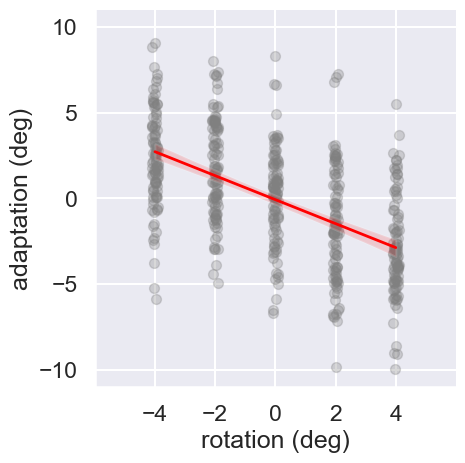

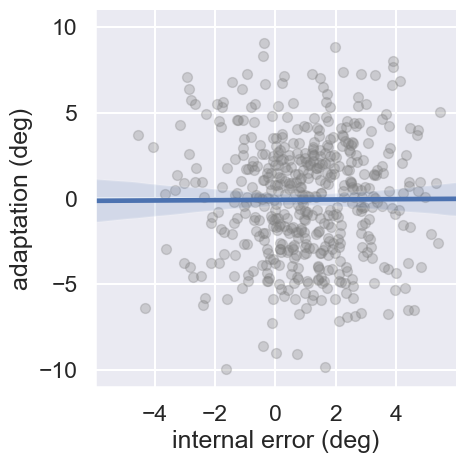

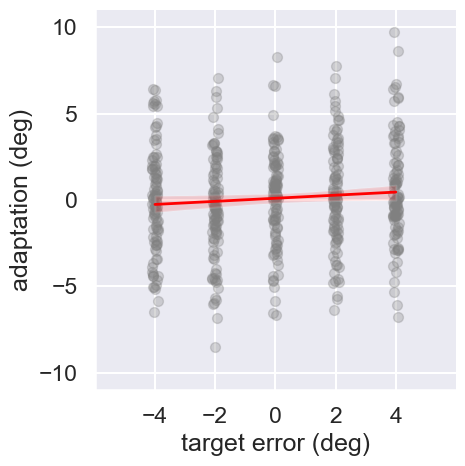

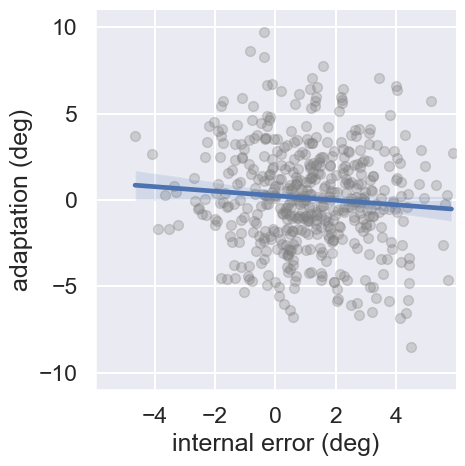

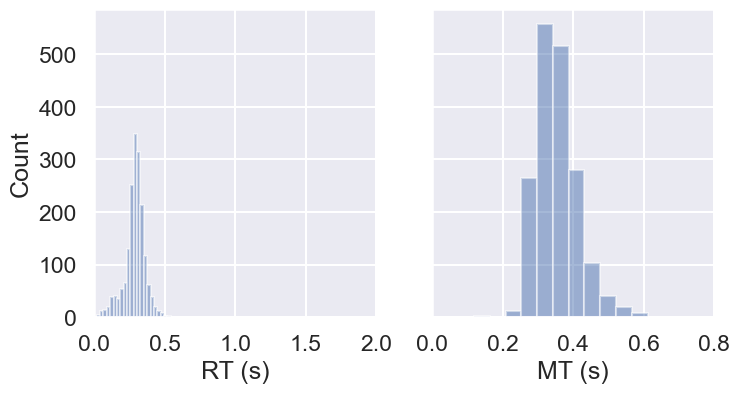

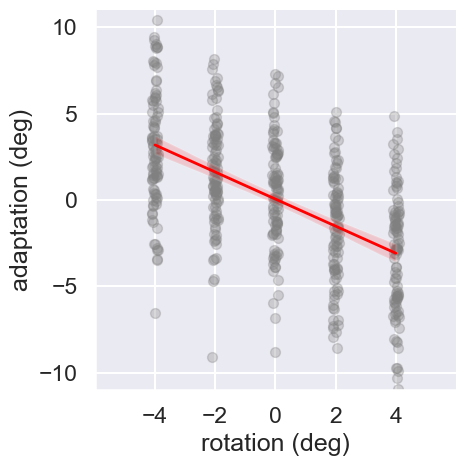

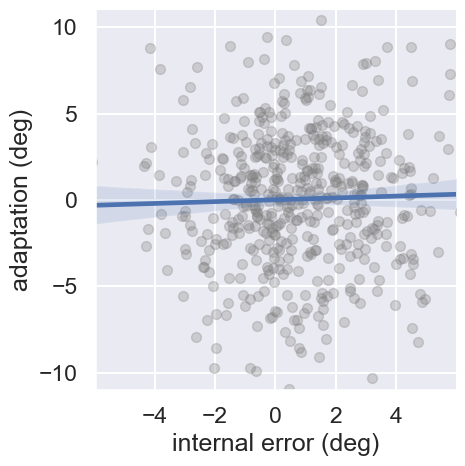

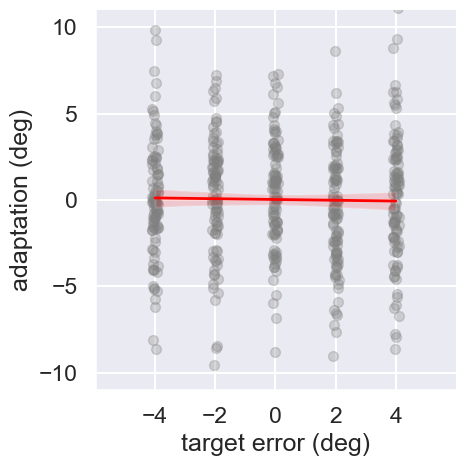

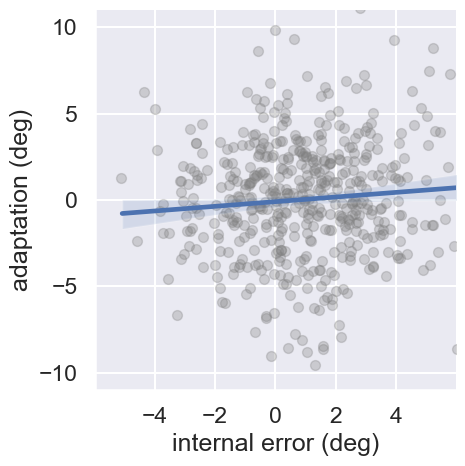

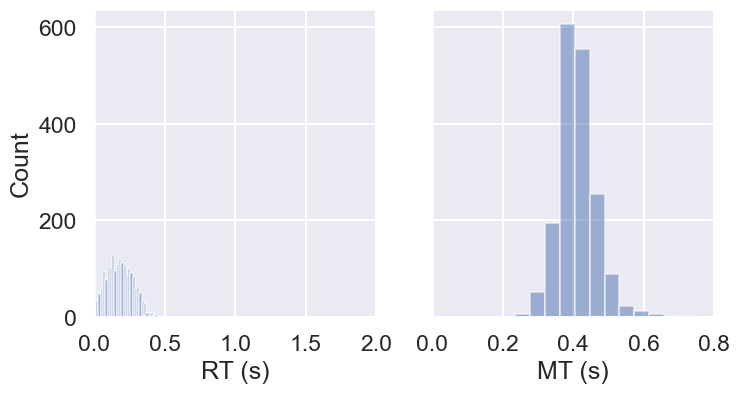

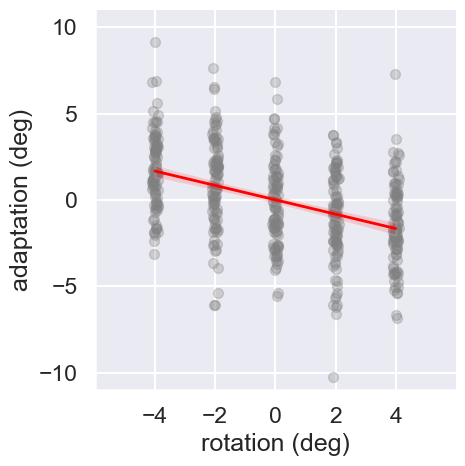

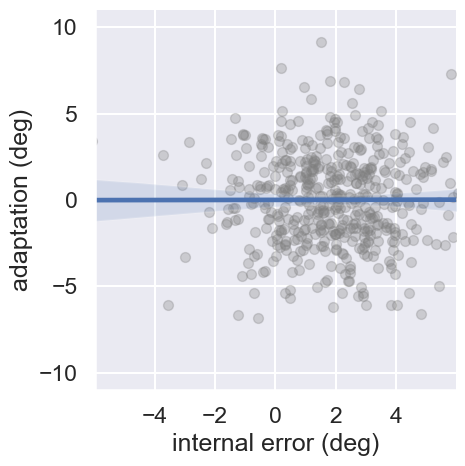

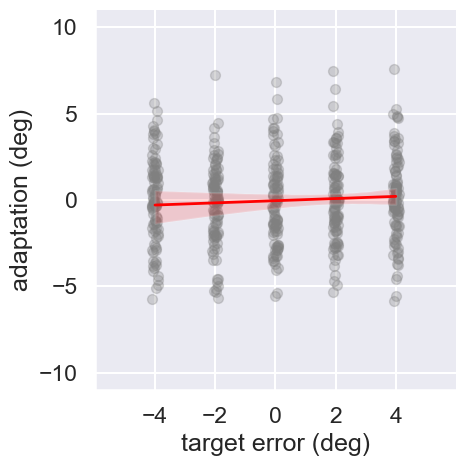

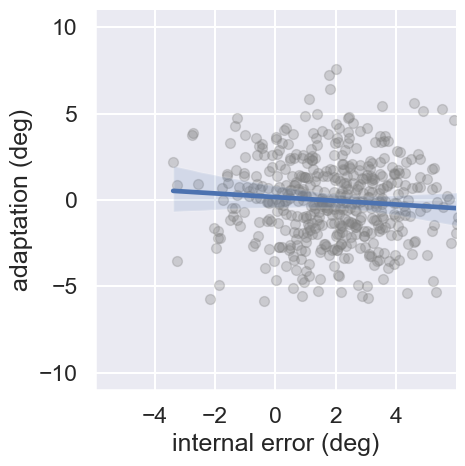

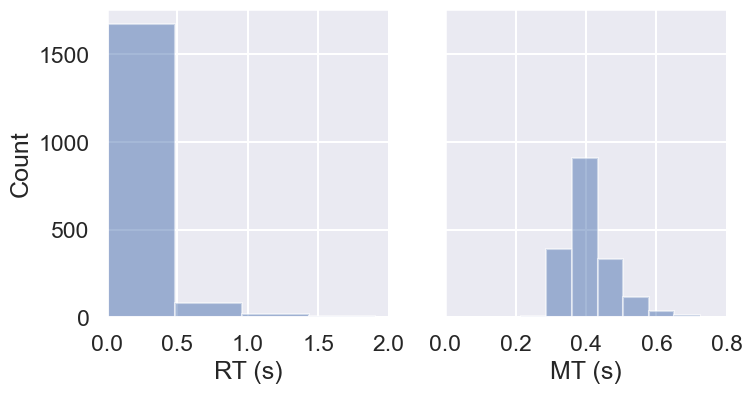

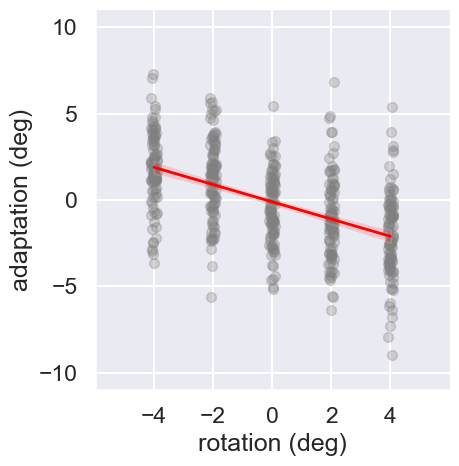

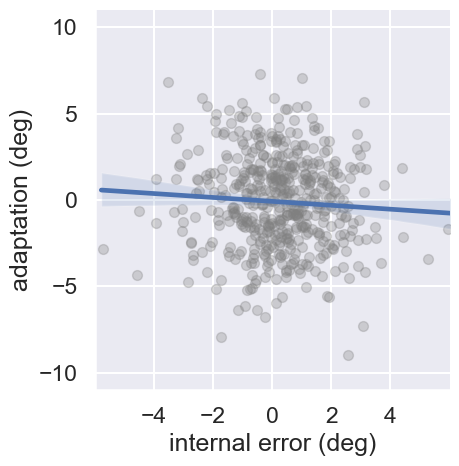

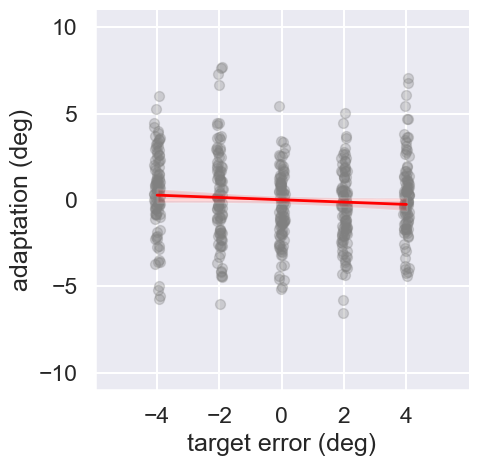

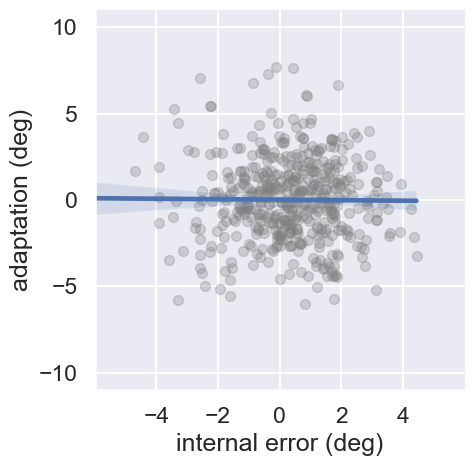

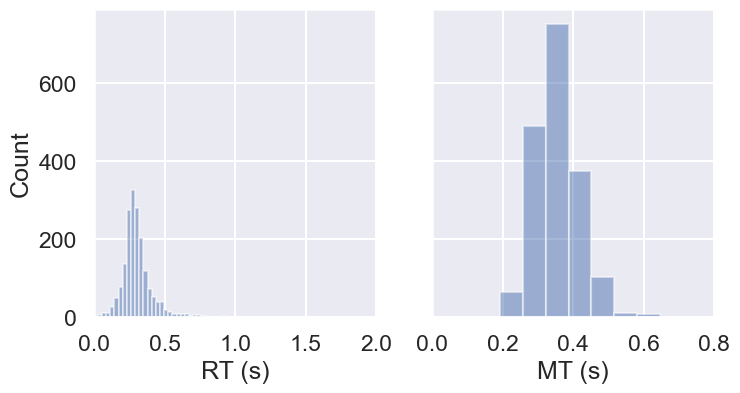

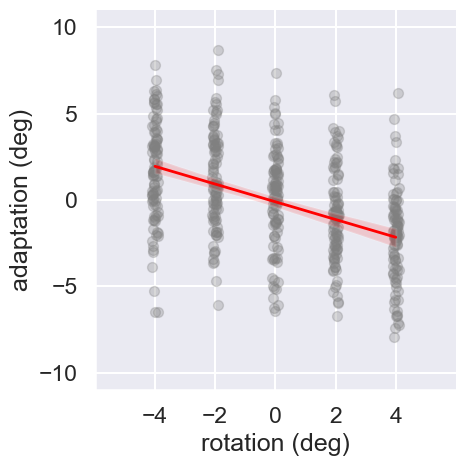

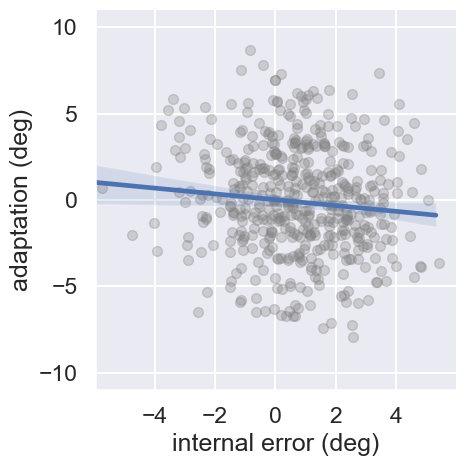

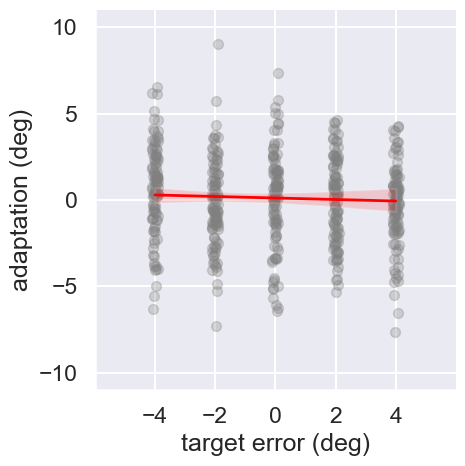

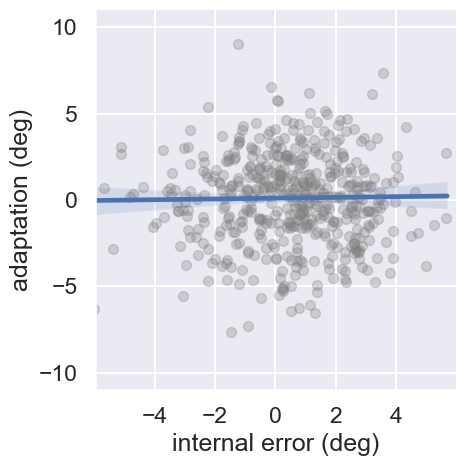

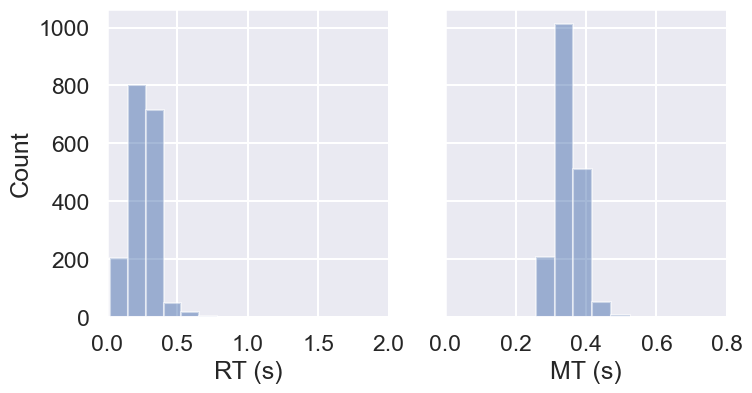

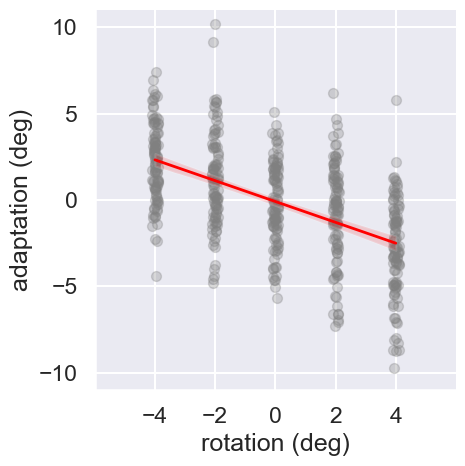

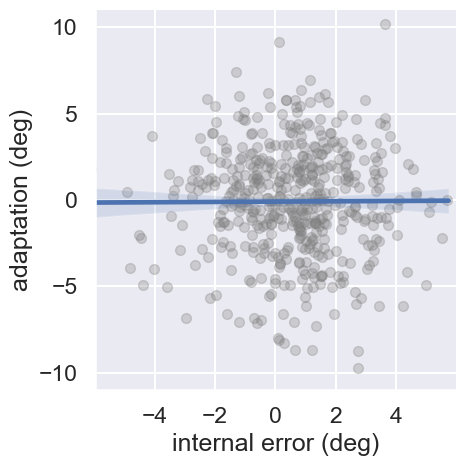

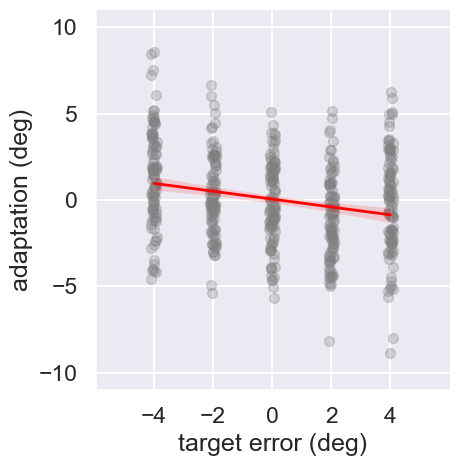

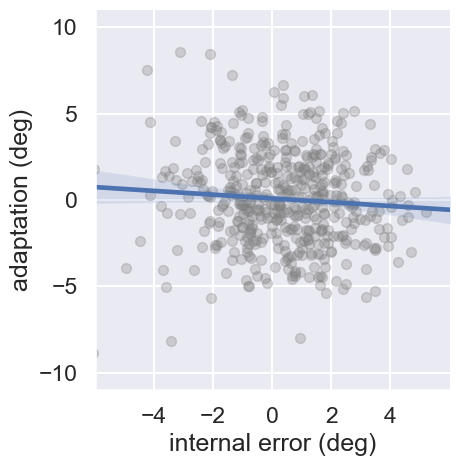

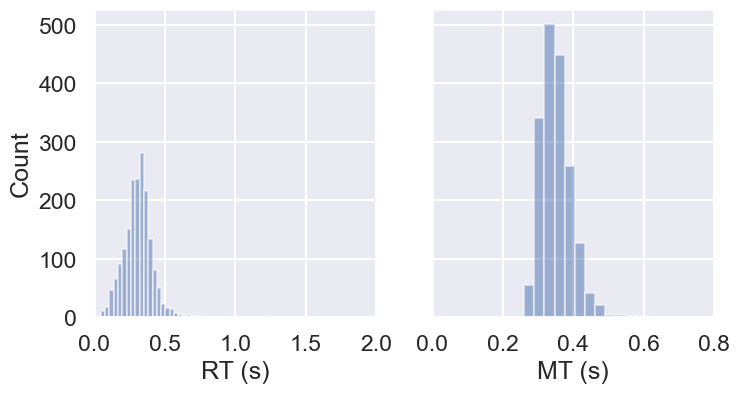

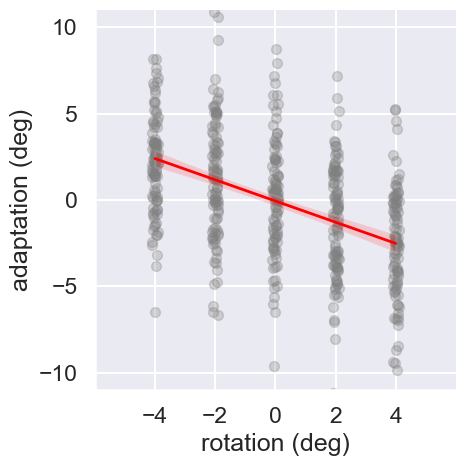

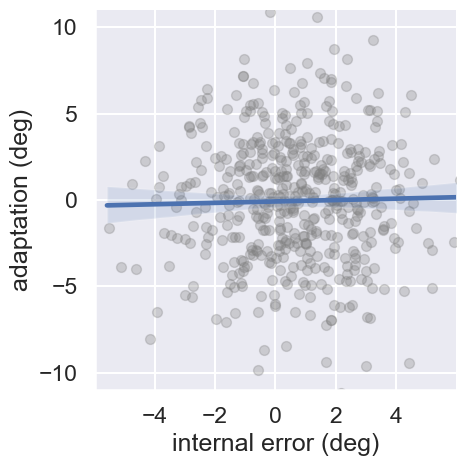

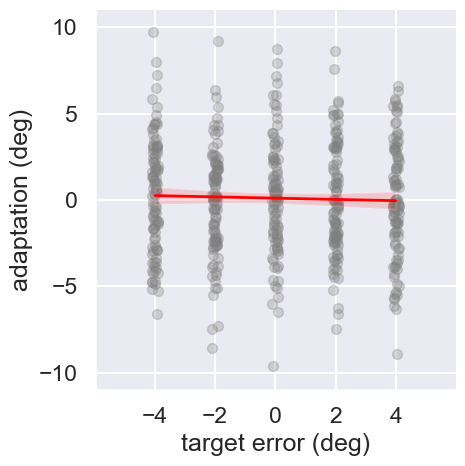

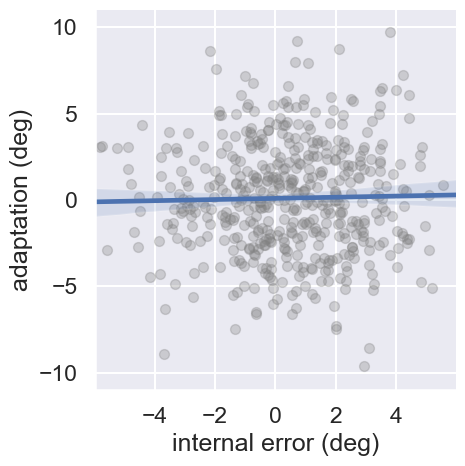

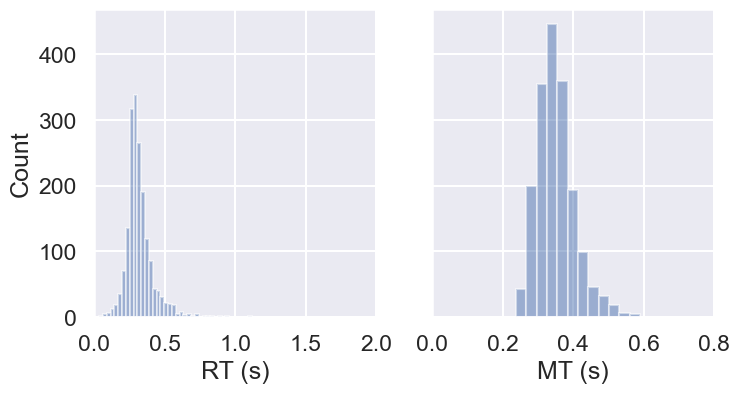

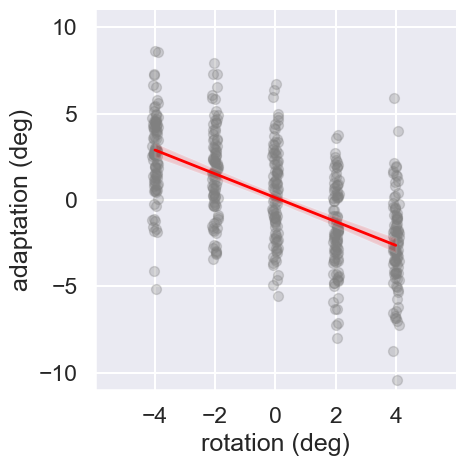

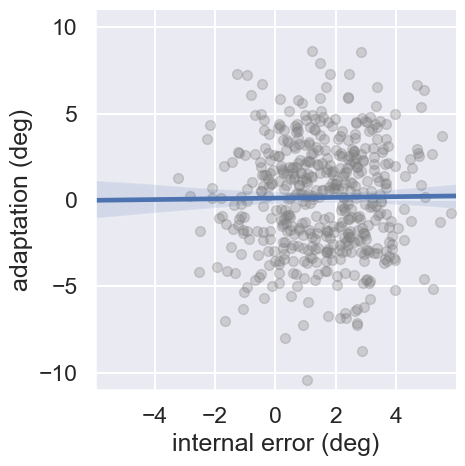

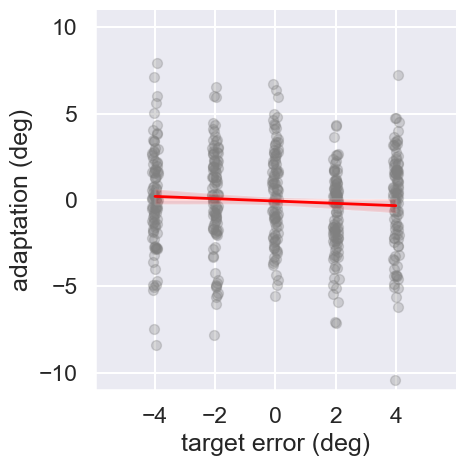

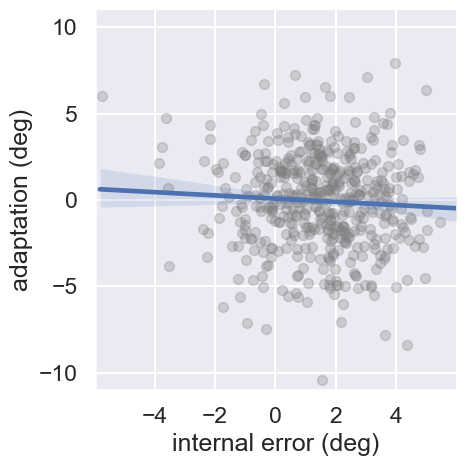

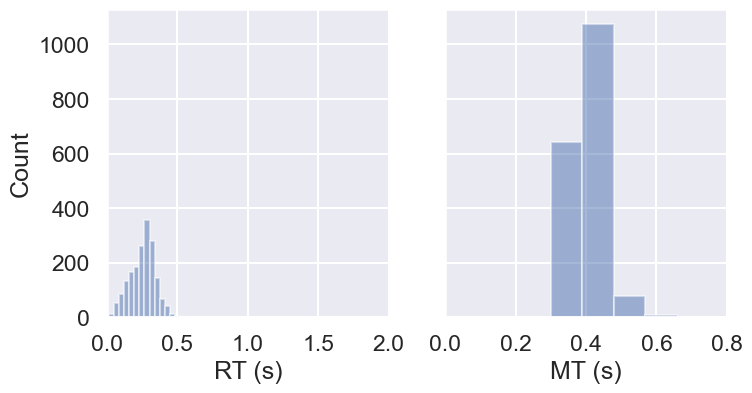

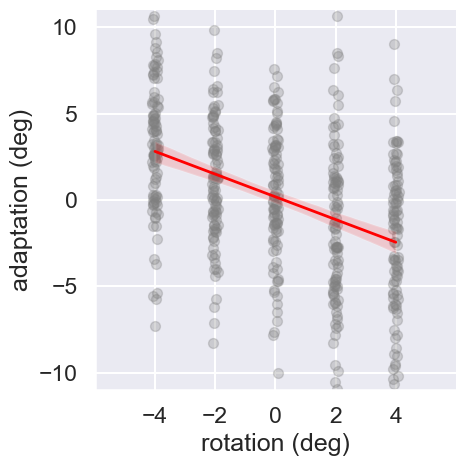

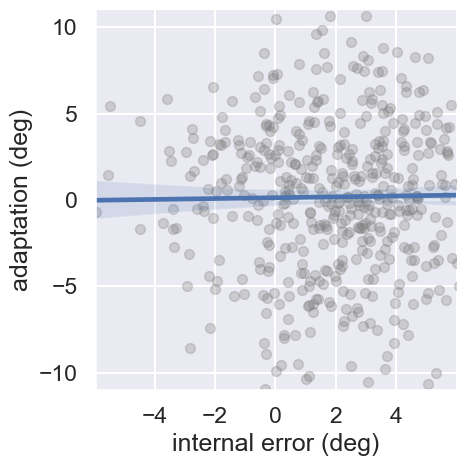

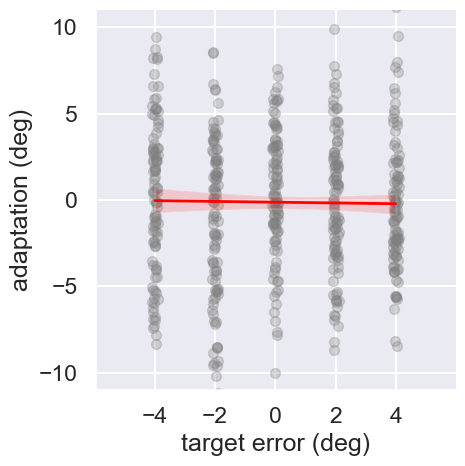

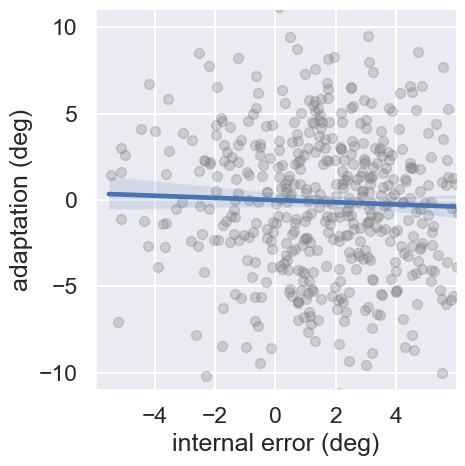

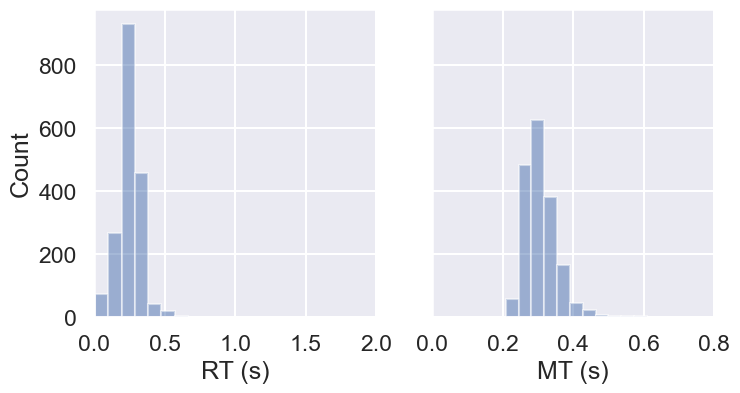

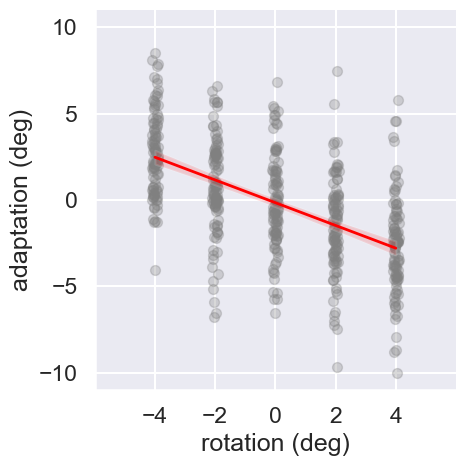

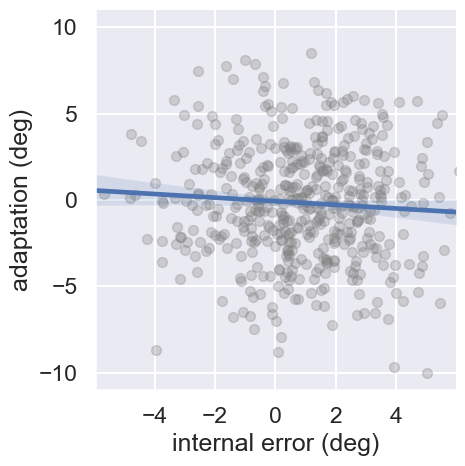

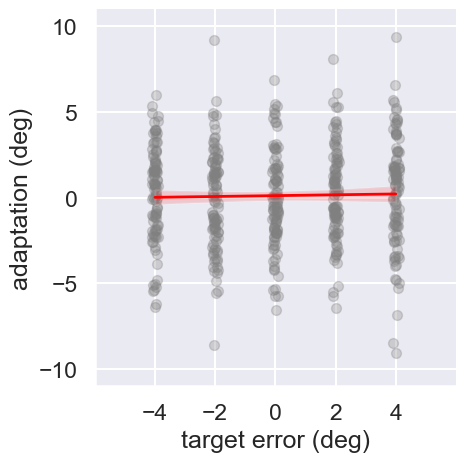

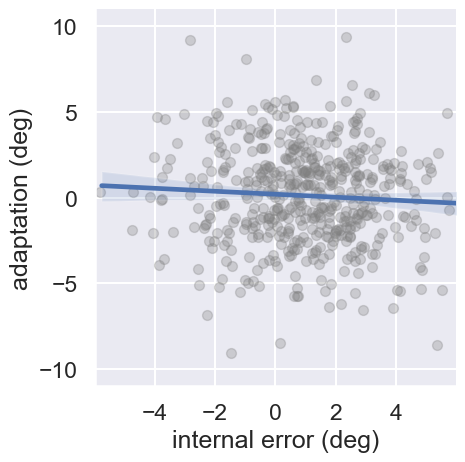

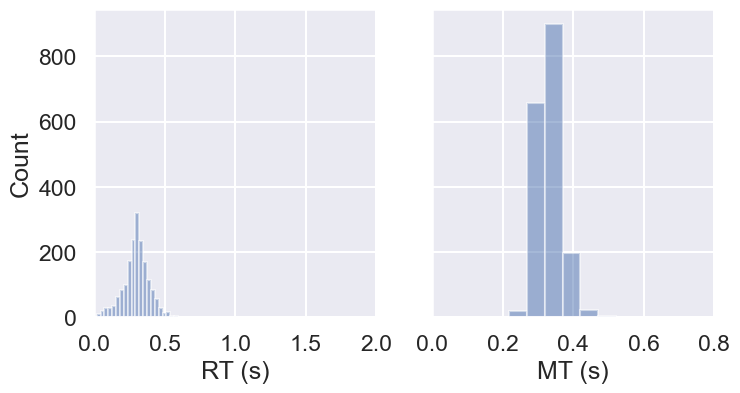

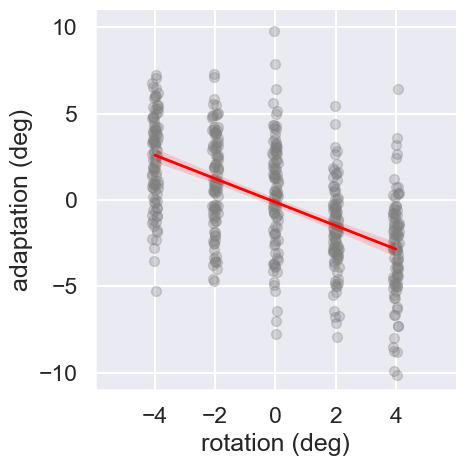

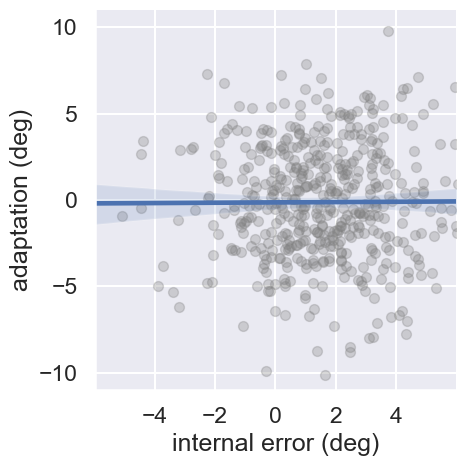

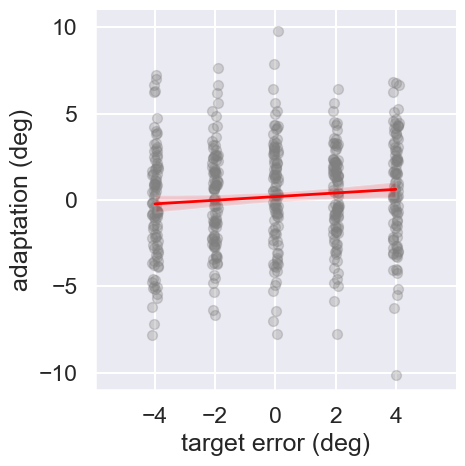

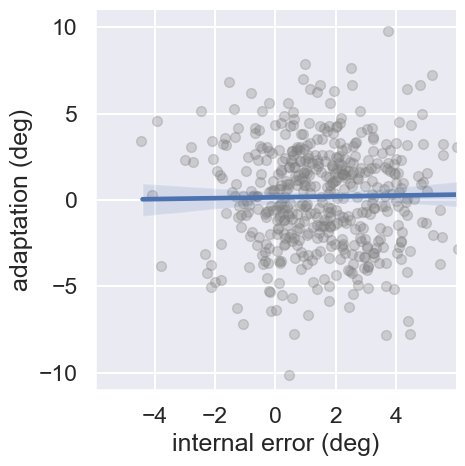

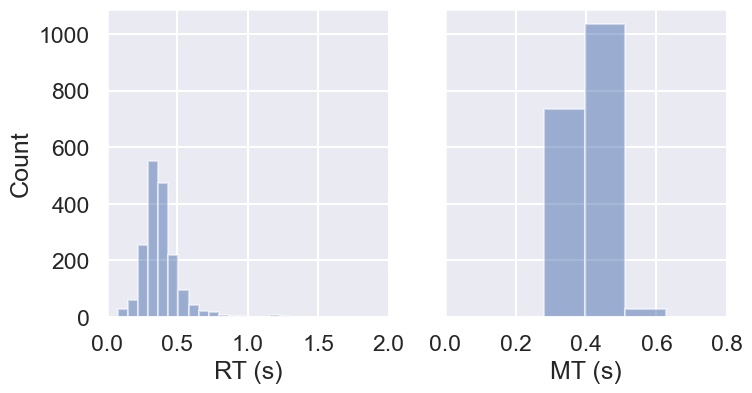

In [9]:
for s in df["id"].unique():
    # Create subject-specific data frame
    subj = df[df["id"] == s].reset_index()
    
    # Create truncated data frame without baseline trials
    training_start = 70
    pert_idx = np.arange(training_start, subj["TN"].max(), 2)
    subj_train = subj.iloc[training_start - 1:, :]
    
    # Loop through trials to get adaptation index
    for i in np.arange(training_start, subj["TN"].max(), 2):
        subj_train.loc[i, "adaptation"] = subj_train.loc[i+1, "theta_maxradv"] - subj_train.loc[i-1, "theta_maxradv"] 
        subj_train.loc[i, "total error"] = subj_train.loc[i, "theta_maxradv"] + subj_train.loc[i, "rotation"]
    
    subj_adapt = subj_train.loc[pert_idx, :].reset_index()
    subj_adapt["tgt_error"] = subj_adapt["tgt_jump"] * -1
    
    # Create separate vmr and target jump data frames
    vmr = subj_adapt.loc[subj_adapt["tgt_jump"] == 0, :]  # Includes 0d rotation
    mask_jump = (subj_adapt["tgt_jump"] != 0) | ((subj_adapt["tgt_jump"] == 0) & (subj_adapt["rotation"] == 0))
    jump = subj_adapt[mask_jump]
    
    # Plot data for adapt vs vmr-ege
    g = sns.lmplot(data=vmr, x="rotation", y="adaptation", x_jitter=0.1, 
               scatter_kws=dict(alpha=0.3, color='gray', s=50), 
               line_kws=dict(linewidth=2, color='red'), ci=95)
    g.set(ylim=(-11, 11), xlim=(-6, 6), xticks=[-4, -2, 0, 2, 4], alpha=0.1, 
      xlabel="rotation (deg)", ylabel="adaptation (deg)")
    # g.savefig("adapt-vmr-ege.png")
    
    # Plot data for adapt vs ige
    g = sns.lmplot(data=vmr, x="theta_maxradv", y="adaptation", x_jitter=0.1, 
               scatter_kws=dict(alpha=0.3, color='gray', s=50), ci=95)
    g.set(ylim=(-11, 11), xlim=(-6, 6), xticks=[-4, -2, 0, 2, 4], alpha=0.1, 
      xlabel="internal error (deg)", ylabel="adaptation (deg)");
    # g.savefig("adapt-vmr-ige.png")

    # Plot data for adapt vs tgt_jump-ege
    g = sns.lmplot(data=jump, x="tgt_error", y="adaptation", x_jitter=0.1, 
                   scatter_kws=dict(alpha=0.3, color='gray', s=50), 
                   line_kws=dict(linewidth=2, color='red'), ci=95)
    g.set(ylim=(-11, 11), xlim=(-6, 6), xticks=[-4, -2, 0, 2, 4], alpha=0.1, 
          xlabel="target error (deg)", ylabel="adaptation (deg)");
    # g.savefig("adapt-target-jump-ege.png")

    # Plot data for adapt vs ige
    g = sns.lmplot(data=jump, x="theta_maxradv", y="adaptation", x_jitter=0.1, 
                   scatter_kws=dict(alpha=0.3, color='gray', s=50))
    g.set(ylim=(-11, 11), xlim=(-6, 6), xticks=[-4, -2, 0, 2, 4], alpha=0.1, 
          xlabel="internal error (deg)", ylabel="adaptation (deg)");
    # g.savefig("adapt-target-jump-ige.png")

    # Plot RTs and MTs
    fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
    ax[0].hist(subj_train["RT"], alpha=0.5, bins=40)
    ax[0].set(xlabel="RT (s)", ylabel="Count", xlim=[0, 2])
    ax[1].hist(subj_train["MT"], alpha=0.5, bins=12)
    ax[1].set(xlabel="MT (s)", xlim=[0, 0.8])

    # Print out statistics
    slope, intercept, r_value, p_value, std_err = stats.linregress(vmr["rotation"], vmr["adaptation"])
    # print(f"Adaptation to ege-vmr has slope of {slope}, p-val of {p_value}.")

    slope, intercept, r_value, p_value, std_err = stats.linregress(vmr["theta_maxradv"], vmr["adaptation"])
    # print(f"Adaptation to ige on rotation trials has slope of {slope}, p-val of {p_value}.")

    slope, intercept, r_value, p_value, std_err = stats.linregress(jump["tgt_error"], jump["adaptation"])
    # print(f"Adaptation to ege-target jump has slope of {slope}, p-val of {p_value}.")

    slope, intercept, r_value, p_value, std_err = stats.linregress(jump["theta_maxradv"], jump["adaptation"])
    # print(f"Adaptation to ige on target jump has slope of {slope}, p-val of {p_value}.")   

In [10]:
# Median RTs
df.groupby("SN")["RT"].median().reset_index(name="RT_median")

,SN,RT_median
0,1,0.298796
1,2,0.188650
2,3,0.263357
3,4,0.292485
4,5,0.265221
5,6,0.312687
6,7,0.305482
7,8,0.267925
8,9,0.264692
9,10,0.305340
